# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Dense, Embedding,Flatten

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [ ]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)
    
    length=len(lookup.get_vocabulary())

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature, length


In [ ]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
def see_result(model,dataframe):
  sample=dataframe.iloc[0].to_dict()
  input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
  test_dict={name: tf.convert_to_tensor(dataframe[name]) for name in input_dict.keys()}

  predictions = model.predict(test_dict)
  target=np.array(dataframe['resale_price'])
  result=np.reshape(np.array(predictions),np.array(dataframe['resale_price']).shape)
  target=tf.convert_to_tensor(target.astype('float64'))
  result=tf.convert_to_tensor(result.astype('float64'))
  return r2(target,result).numpy()

# Question 1 part a

Because the data might be time-dependent. Random split assumes that variables are independant, which is not the case here. Ideally, we want to based on past experiences (before 2020) and test for new data(after 2020).

In [ ]:
# Split data

train_dataframe = df[df['year']<=2020]
val_dataframe = df[df['year']>2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

# Question 1 part b

In [ ]:
BATCH_SIZE=256
LR=0.001
EPOCH=50


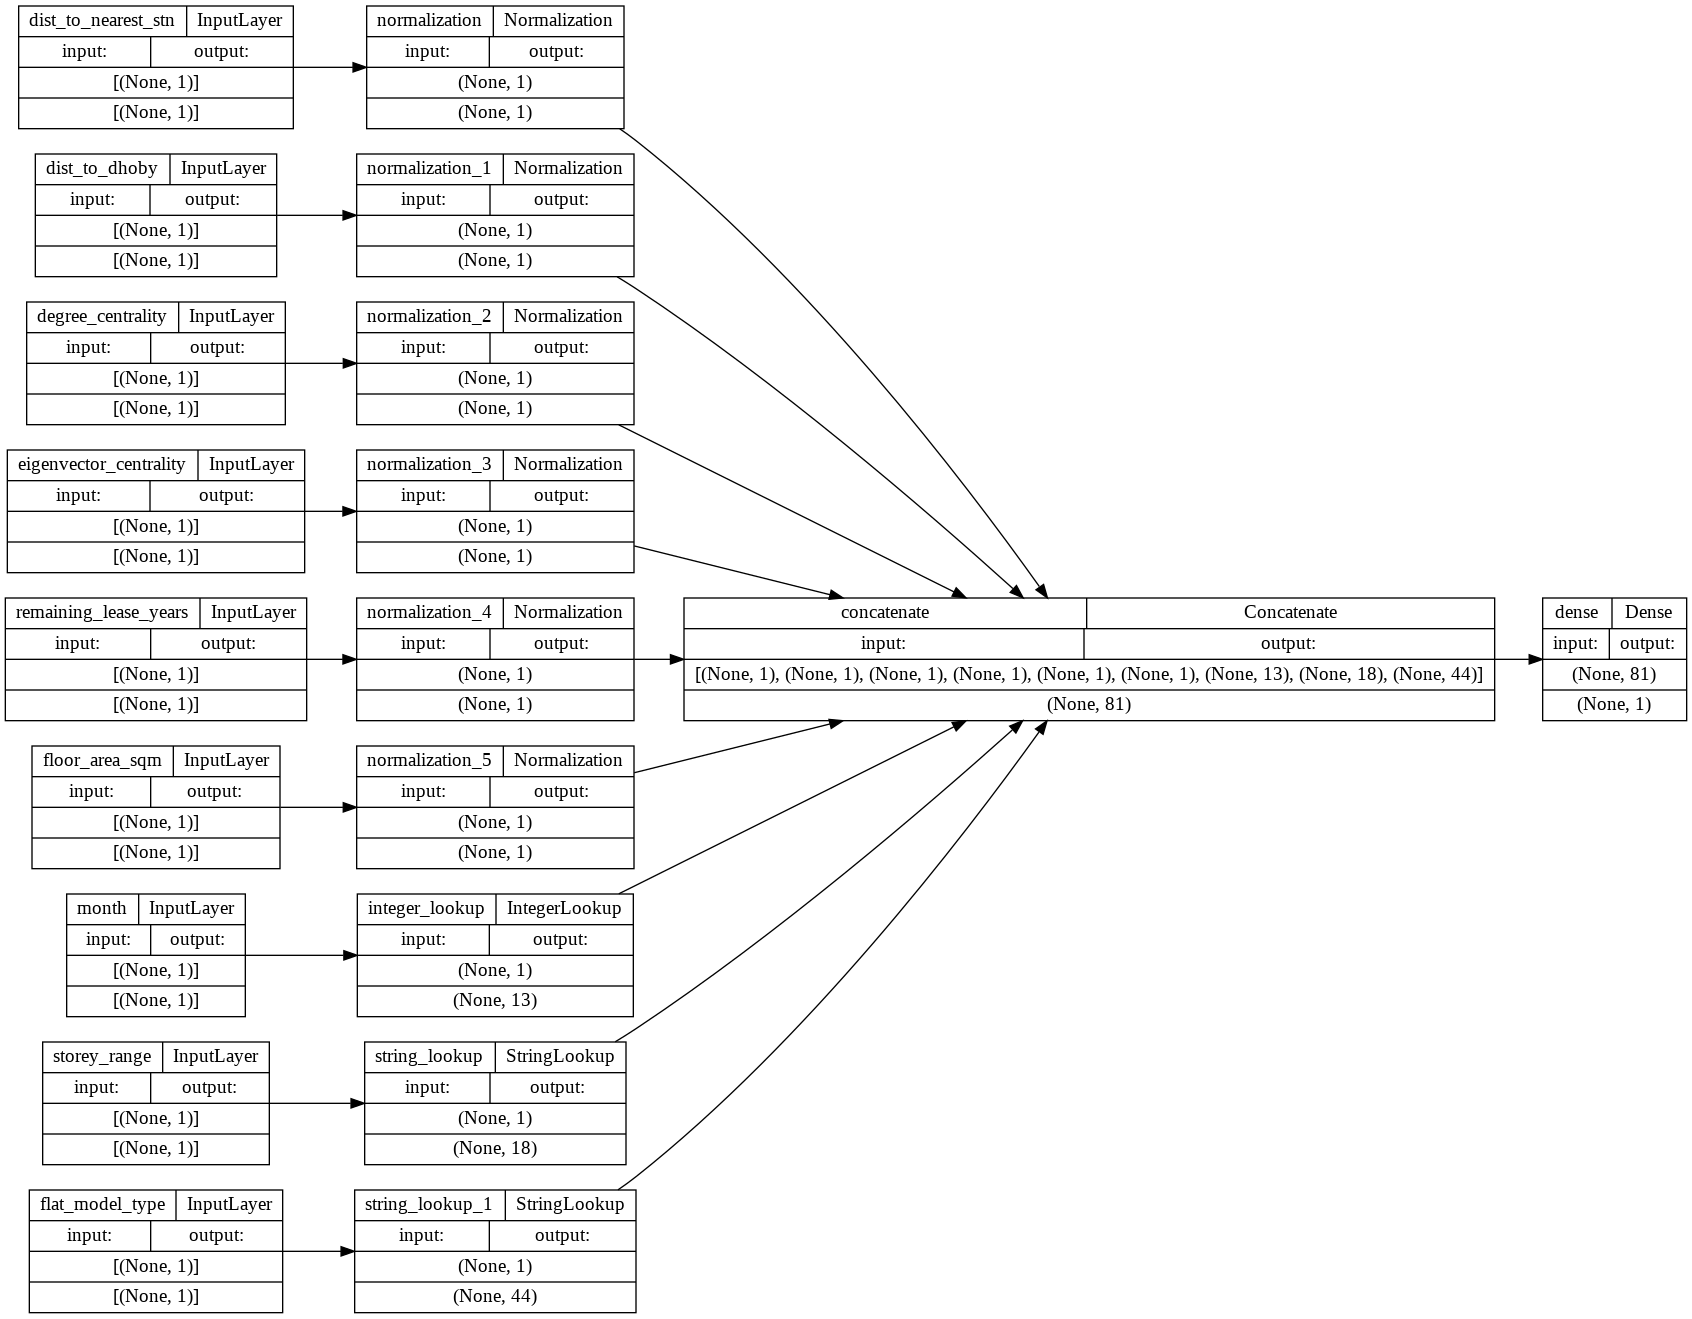

In [ ]:
numerical=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
encoded=[]
input=[]
for item in numerical:
  encoded_item=keras.Input(shape=(1,), name=item)
  input.append(encoded_item)
  encoded.append(encode_numerical_feature(encoded_item, item, train_ds))


month=keras.Input(shape=(1,), name='month',dtype="int64")
input.append(month)
encoded.append(encode_categorical_feature(month, 'month', train_ds,False)[0])

storey_range=keras.Input(shape=(1,), name='storey_range',dtype="string")
input.append(storey_range)
encoded.append(encode_categorical_feature(storey_range, 'storey_range', train_ds,True)[0])

flat_model_type=keras.Input(shape=(1,), name='flat_model_type',dtype="string")
input.append(flat_model_type)
encoded.append(encode_categorical_feature(flat_model_type, 'flat_model_type', train_ds,True)[0])

encoded_features = layers.concatenate(encoded)

x=Dense(1)(encoded_features)
model = keras.Model(input, x)
model.compile(tf.keras.optimizers.Adam(learning_rate=LR), loss="mean_squared_error", metrics=["mean_squared_error"])
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Question 1 part c

In [ ]:
model.fit(train_ds, verbose=0, epochs=EPOCH, batch_size=BATCH_SIZE,validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
print(see_result(model,val_dataframe))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'resale_price'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


-9.940560039102856


In [ ]:
BATCH_SIZE=256
LR=0.01
EPOCH=50


In [ ]:
numerical=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
encoded=[]
input=[]
for item in numerical:
  encoded_item=keras.Input(shape=(1,), name=item)
  input.append(encoded_item)
  encoded.append(encode_numerical_feature(encoded_item, item, train_ds))


month=keras.Input(shape=(1,), name='month',dtype="int64")
input.append(month)
encoded.append(encode_categorical_feature(month, 'month', train_ds,False)[0])

flat_model_type=keras.Input(shape=(1,), name='flat_model_type',dtype="string")
input.append(flat_model_type)
encoded.append(encode_categorical_feature(flat_model_type, 'flat_model_type', train_ds,True)[0])

storey_range=keras.Input(shape=(1,), name='storey_range',dtype="string")
input.append(storey_range)

encoded.append(encode_categorical_feature(storey_range, 'storey_range', train_ds,True)[0])

encoded_features = layers.concatenate(encoded)
x=Dense(1)(encoded_features)
model = keras.Model(input, x)
model.compile(tf.keras.optimizers.SGD(learning_rate=LR), loss="mean_squared_error", metrics=["mean_squared_error"])
model.fit(train_ds, verbose=0, epochs=EPOCH, batch_size=BATCH_SIZE,validation_data=val_ds)

In [ ]:
print(see_result(model,val_dataframe))

0.6145235694120081


ADAM produces worse results than SGD: it has r^2 of around -9 while SGD has r^2 of around 0.6. This is because ADAM uses momentum to reach the lowest point, and learning rate is the 'amount of step' it takes. When it is initialising, m0=v0=0, and m1=0.1 x g1, v1= 0.01 x g1^2. The amount it minus from original weight is learning_rate x m1/0.1/(sqrt(v1/0.01)+epsilon)=learning_rate x 10m1/(10sqrt(v1)+epsilon)=learning_rate x g1/(g1+epsilon), and it is a very small number. That causes the weights to be updated very minimally each step, and it cannot reach optimal value in 50 epochs.

SGD however only multiply learning_rate with gradient, and since the gradient is pretty large for such a large loss, it is able to descend and reach for global minima.

# QUESTION 1 part d

In [ ]:
BATCH_SIZE=256
LR=0.08
EPOCH=50

numerical=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
encoded=[]
input=[]
for item in numerical:
  encoded_item=keras.Input(shape=(1,), name=item)
  input.append(encoded_item)
  encoded.append(encode_numerical_feature(encoded_item, item, train_ds))


month=keras.Input(shape=(1,), name='month',dtype="int64")
input.append(month)
encoded.append(encode_categorical_feature(month, 'month', train_ds,False)[0])

flat_model_type=keras.Input(shape=(1,), name='flat_model_type',dtype="string")
input.append(flat_model_type)
encoded.append(encode_categorical_feature(flat_model_type, 'flat_model_type', train_ds,True)[0])

storey_range=keras.Input(shape=(1,), name='storey_range',dtype="string")
input.append(storey_range)

encoded.append(encode_categorical_feature(storey_range, 'storey_range', train_ds,True)[0])

encoded_features = layers.concatenate(encoded)

x=Dense(10,activation='relu')(encoded_features)
x=Dense(1)(x)
model = keras.Model(input, x)
model.compile(tf.keras.optimizers.Adam(learning_rate=LR), loss="mean_squared_error", metrics=["mean_squared_error"])
history=model.fit(train_ds, verbose=0, epochs=EPOCH, batch_size=BATCH_SIZE,validation_data=val_ds)



In [ ]:
print(see_result(model,val_dataframe))

0.663731318487805


# Question 1 part e

Q1d model gives a better test r^2 of 0.67 than Q1c of 0.61. Q1c only uses 1 line to fit all while Q1d uses many line segments, and it might be a better approximation to data not really fit to a one-line graph.

# Question 2 part a

In [ ]:
train_dataframe = df[df['year']<2020]
val_dataframe = df[df['year']==2020]
test_dataframe=df[df['year']>2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

# Question 2 part b

In [ ]:
BATCH_SIZE=256
LR=0.008
EPOCH=50
DIVISOR=1

In [ ]:
from math import floor

def embed_and_flatten(feature,name,train_ds,is_string):
  feature,num_cat=encode_categorical_feature(feature,name, train_ds,is_string)
  layer=Embedding(input_dim=feature.shape[1],output_dim=floor(num_cat/DIVISOR))(feature)
  layer=Flatten()(layer)
  return layer

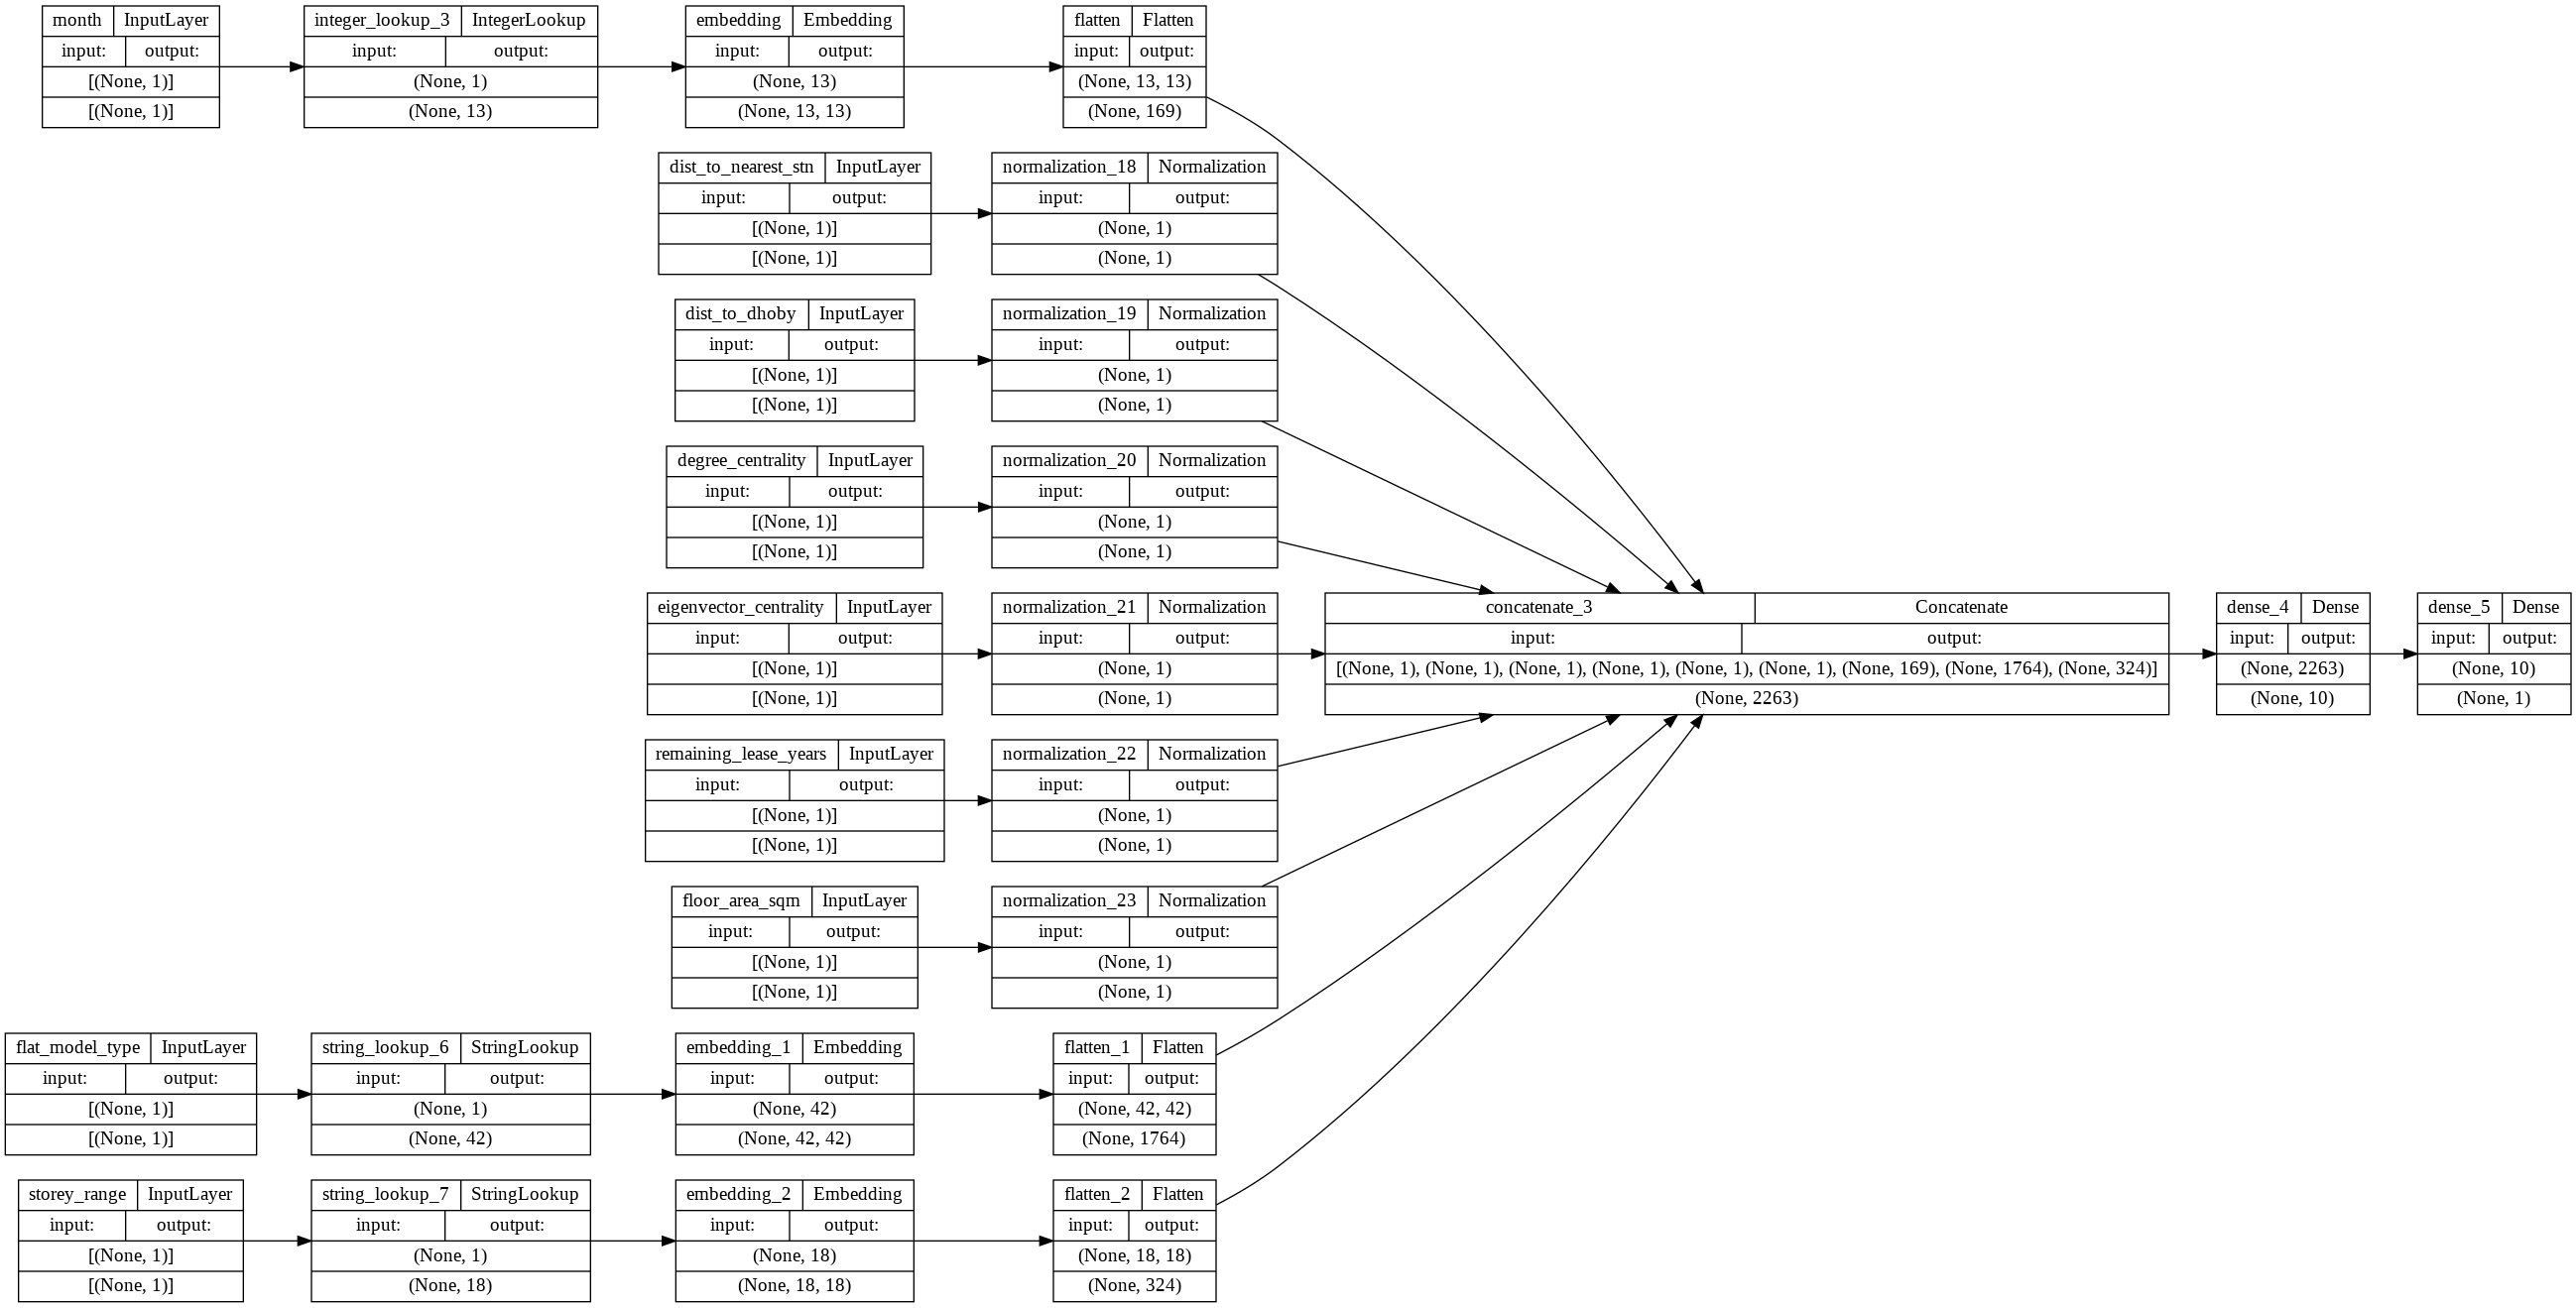

In [ ]:
numerical=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
encoded=[]
input=[]
for item in numerical:
  encoded_item=keras.Input(shape=(1,), name=item)
  input.append(encoded_item)
  encoded.append(encode_numerical_feature(encoded_item, item, train_ds))


month=keras.Input(shape=(1,), name='month',dtype="int64")
input.append(month)
encoded.append(embed_and_flatten(month,'month',train_ds,False))

flat_model_type=keras.Input(shape=(1,), name='flat_model_type',dtype="string")
input.append(flat_model_type)
encoded.append(embed_and_flatten(flat_model_type,'flat_model_type',train_ds,True))

storey_range=keras.Input(shape=(1,), name='storey_range',dtype="string")
input.append(storey_range)
encoded.append(embed_and_flatten(storey_range,'storey_range',train_ds,True))

encoded_features=layers.concatenate(encoded)
x=Dense(10,activation='relu')(encoded_features)
x=Dense(1)(x)
model = keras.Model(input, x)
model.compile(tf.keras.optimizers.Adam(learning_rate=LR), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


# Question 2 part c

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 30.8 MB/s 
     |████████████████████████████████| 1.6 MB 38.1 MB/s 


In [ ]:
def embed_and_flatten_vary_div(feature,name,train_ds,is_string,div):
  feature,num_cat=encode_categorical_feature(feature,name, train_ds,is_string)
  layer=Embedding(input_dim=feature.shape[1],output_dim=floor(num_cat/div))(feature)
  layer=Flatten()(layer)
  return layer

In [ ]:
def build_model(hp):
  div=hp.Int('divisor',1, 2, step=1 )

  numerical=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
  encoded=[]
  input=[]
  for item in numerical:
    encoded_item=keras.Input(shape=(1,), name=item)
    input.append(encoded_item)
    encoded.append(encode_numerical_feature(encoded_item, item, train_ds))

  encoded_features=layers.concatenate(encoded)

  month=keras.Input(shape=(1,), name='month',dtype="int64")
  input.append(month)
  encoded.append(embed_and_flatten_vary_div(month,'month',train_ds,False,div))

  flat_model_type=keras.Input(shape=(1,), name='flat_model_type',dtype="string")
  input.append(flat_model_type)
  encoded.append(embed_and_flatten_vary_div(flat_model_type,'flat_model_type',train_ds,True,div))

  storey_range=keras.Input(shape=(1,), name='storey_range',dtype="string")
  input.append(storey_range)
  encoded.append(embed_and_flatten_vary_div(storey_range,'storey_range',train_ds,True,div))

  x=Dense(hp.Int('neuron', 4,32,step=4),activation='relu')(encoded_features)
  x=Dense(1)(x)
  model = keras.Model(input, x)
  model.compile(tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', 1e-4, 2e-1, sampling='log' )), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])
  return model


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

In [ ]:
tuner.search(train_ds,epochs=50, validation_data=val_ds,callbacks=[stop_early])

Trial 10 Complete [00h 02m 44s]
val_loss: 223442108416.0

Best val_loss So Far: 3876238080.0
Total elapsed time: 00h 24m 55s


In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
LR=best_hps.get('lr')
NEURON=best_hps.get('neuron')
DIVISOR=best_hps.get('divisor')

Best result:



In [ ]:
print("lr: ",best_hps.get('lr'))
print("neuron: ",best_hps.get('neuron'))
print("divisor",best_hps.get('divisor'))

lr:  0.06805250998340012
neuron:  16
divisor 2


# Question 2 part d

In [ ]:
BATCH_SIZE=256
EPOCH=50

In [ ]:
def embed_and_flatten(feature,name,train_ds,is_string):
  feature,num_cat=encode_categorical_feature(feature,name, train_ds,is_string)
  layer=Embedding(input_dim=feature.shape[1],output_dim=floor(num_cat/DIVISOR))(feature)
  layer=Flatten()(layer)
  return layer

In [ ]:
numerical=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
encoded=[]
input=[]
for item in numerical:
  encoded_item=keras.Input(shape=(1,), name=item)
  input.append(encoded_item)
  encoded.append(encode_numerical_feature(encoded_item, item, train_ds))


month=keras.Input(shape=(1,), name='month',dtype="int64")
input.append(month)
encoded.append(embed_and_flatten(month,'month',train_ds,False))

flat_model_type=keras.Input(shape=(1,), name='flat_model_type',dtype="string")
input.append(flat_model_type)
encoded.append(embed_and_flatten(flat_model_type,'flat_model_type',train_ds,True))

storey_range=keras.Input(shape=(1,), name='storey_range',dtype="string")
input.append(storey_range)
encoded.append(embed_and_flatten(storey_range,'storey_range',train_ds,True))

encoded_features=layers.concatenate(encoded)
x=Dense(NEURON,activation='relu')(encoded_features)
x=Dense(1)(x)
model = keras.Model(input, x)
model.compile(tf.keras.optimizers.Adam(learning_rate=LR), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error')])
checkpoint_filepath = '/content/drive/MyDrive/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history=model.fit(train_ds, verbose=1, epochs=EPOCH, batch_size=BATCH_SIZE,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),model_checkpoint_callback], validation_data=val_ds)


Epoch 1/50
251/251 [==============================] - 8s 28ms/step - loss: 46661541888.0000 - mean_squared_error: 46661541888.0000 - root_mean_squared_error: 216012.8281 - val_loss: 23601922048.0000 - val_mean_squared_error: 23601922048.0000 - val_root_mean_squared_error: 153629.1719
Epoch 2/50
251/251 [==============================] - 6s 22ms/step - loss: 22324852736.0000 - mean_squared_error: 22324852736.0000 - root_mean_squared_error: 149415.0312 - val_loss: 18902894592.0000 - val_mean_squared_error: 18902894592.0000 - val_root_mean_squared_error: 137487.7969
Epoch 3/50
251/251 [==============================] - 7s 25ms/step - loss: 13132145664.0000 - mean_squared_error: 13132145664.0000 - root_mean_squared_error: 114595.5781 - val_loss: 10321852416.0000 - val_mean_squared_error: 10321852416.0000 - val_root_mean_squared_error: 101596.5156
Epoch 4/50
251/251 [==============================] - 7s 25ms/step - loss: 8929270784.0000 - mean_squared_error: 8929270784.0000 - root_mean_squa

In [ ]:
rmse_v=history.history['val_root_mean_squared_error']
rmse_t=history.history['root_mean_squared_error']

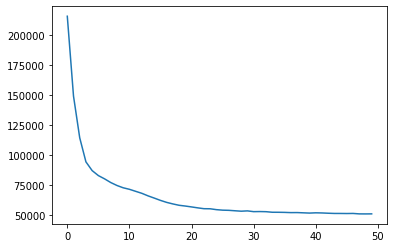

In [ ]:
plt.plot([i for i in range(len(rmse_t))],rmse_t)
plt.show()

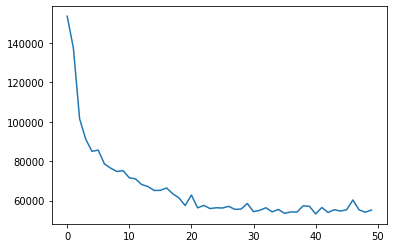

In [ ]:
plt.plot([i for i in range(len(rmse_v))],rmse_v)
plt.show()

In [ ]:
best_model=tf.keras.models.load_model(checkpoint_filepath)

In [ ]:
print(see_result(best_model,test_dataframe))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'resale_price'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


0.7128973787479909


# Question 2 part e

In [ ]:
sample=test_dataframe.iloc[0].to_dict()
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
test_dict={name: tf.convert_to_tensor(test_dataframe[name]) for name in input_dict.keys()}

predictions = best_model.predict(test_dict)
target=np.array(test_dataframe['resale_price'])
result=np.reshape(np.array(predictions),np.array(test_dataframe['resale_price']).shape)
true_error=target-result
error=abs(target-result)

test_dataframe['error']=error
test_dataframe['true_error']=true_error


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
test_dataframe.nlargest(30,'error')

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,error,true_error
117054,4,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.166667,113.0,28 TO 30,1150000.0,474116.2500,474116.2500
114504,12,2021,6 TOH YI DRIVE,Beauty World,0.428356,8.948410,0.016807,0.001358,"EXECUTIVE, Maisonette",66.666667,154.0,04 TO 06,1238000.0,465865.4375,465865.4375
117107,7,2022,104A ANG MO KIO STREET 11,Ang Mo Kio,1.216557,8.071776,0.016807,0.006243,"EXECUTIVE, Apartment",72.833333,146.0,04 TO 06,1120000.0,446581.1875,446581.1875
117058,6,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.083333,113.0,19 TO 21,1100000.0,440173.5000,440173.5000
120164,1,2022,2 TOH YI DRIVE,Beauty World,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.666667,146.0,07 TO 09,1202000.0,432417.3125,432417.3125
117061,7,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.000000,113.0,25 TO 27,1100000.0,431665.4375,431665.4375
117052,2,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.333333,113.0,16 TO 18,1050000.0,431207.6875,431207.6875
117057,5,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.083333,113.0,13 TO 15,1028000.0,427179.9375,427179.9375
117060,7,2022,260B ANG MO KIO STREET 21,Ang Mo Kio,1.745057,7.818413,0.016807,0.006243,"5 ROOM, Improved",95.000000,113.0,13 TO 15,1025000.0,424945.9375,424945.9375
111790,11,2021,46 SENG POH ROAD,Tiong Bahru,0.581977,2.309477,0.016807,0.047782,"3 ROOM, Standard",50.166667,88.0,01 TO 03,780000.0,424901.4375,424901.4375


In [ ]:
error_frame=test_dataframe.nlargest(30,'error')

In [ ]:
import seaborn as sns

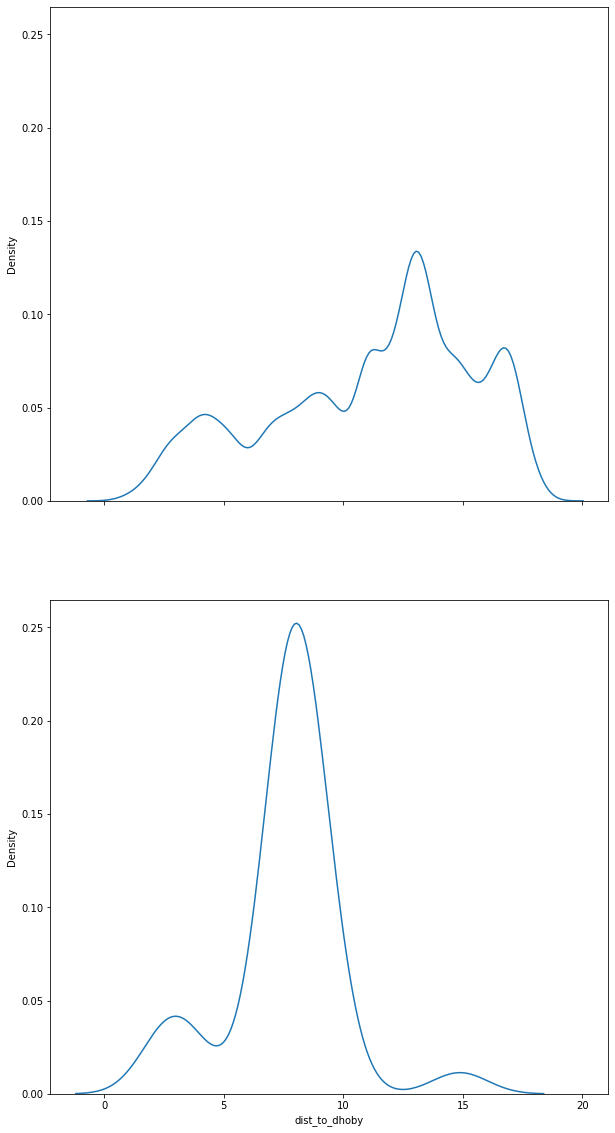

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(10,20),sharex=True,sharey=True)
sns.kdeplot(data=train_dataframe,x='dist_to_dhoby',ax=axes[0])
sns.kdeplot(data=error_frame,x='dist_to_dhoby',ax=axes[1])
plt.show()

From the plot we see that the main reason for the deviation is probably the dist_to_dhoby. The first plot is the distribution of it over train dataset, and the second is its distribution over the error data frame. In the error frame, it shows most of them are < 10, while in the train dataframe most of them is > 10. It could be that model does not place a great emphasis on this feature when evaluating the data points in the error dataframe, and thus underestimate its price.

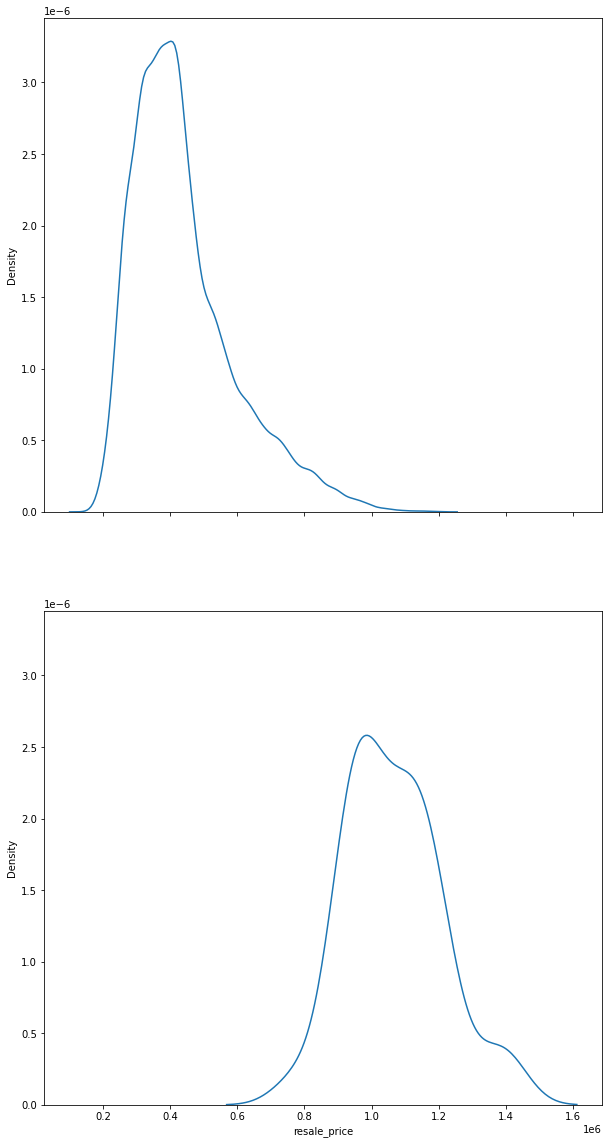

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(10,20),sharex=True,sharey=True)
sns.kdeplot(data=train_dataframe,x='resale_price',ax=axes[0])
sns.kdeplot(data=error_frame,x='resale_price',ax=axes[1])
plt.show()

In the training dataframe (the first one), the resale price is mostly in the lower ends, and there is few data above 1.0 e6, but in the error dataframe (the one below) most of them is about 1.0 e6. The lack of attribute data leading to such a high price also might contribute to the errors in prediction.

In [ ]:
error_frame['flat_model_type'].value_counts()

5 ROOM, Improved                  11
5 ROOM, Standard                   9
EXECUTIVE, Maisonette              5
EXECUTIVE, Apartment               2
3 ROOM, Standard                   1
4 ROOM, Premium Apartment Loft     1
4 ROOM, Model A                    1
Name: flat_model_type, dtype: int64

In [ ]:
print("number of 5 ROOM, Improved/total number of records is : ",len(train_dataframe[train_dataframe['flat_model_type']=='5 ROOM, Improved'])/len(train_dataframe))

number of 5 ROOM, Improved/total number of records is :  0.17201867087125527


This is defintly smaller than the proportion of 5 ROOM, Improved in the error frame (11/30), and it might be because the 5 rooms are increasing in number in recent years, and the lack of data in its attribute does not help the model to form a useful pattern to estimate the price.

Notice that 5 ROOMS, IMPROVED, resale price > 1.0e6, and dist_to_dhoby < 10 mostly appear in the same row. That means samples with these particular attributes are 'outliers' for our model. A way to help is to upsample such data points so the model recognize them better, or just to go and collect more of such types of data.

We should also investigate on why they give so high a deviation. It might be because of factors that the model is not accounted for (i.e. not inside its input features), such as a sudden beneficial policy announced regarding this particular type of housing.

# Question 3 part a

In [ ]:
df_old = pd.read_csv('/content/drive/MyDrive/hdb_price_prediction_old.csv')

In [ ]:
old_test_dataframe = df_old[df_old['year']>2020]
new_test_dataframe_2021 = df[df['year']==2021]
new_test_dataframe_2022 = df[df['year']==2022]

old dataset:

In [ ]:
print(see_result(best_model,old_test_dataframe))

0.835591688647964


dataset of 2021:

In [ ]:
print(see_result(best_model,new_test_dataframe_2021))

0.7919268116759629


dataset of 2022:

In [ ]:
print(see_result(best_model,new_test_dataframe_2022))

0.5819242256719099


# Question 3 part b

It seems that the model degradation has indeed occured. The old dataset it achieves about 0.84 fit, while in 2021 test set it is about 0.79, and it is about 0.58 for 2022. The severity of degradation is slightly better for my model than the team's.

This occurs probably because there is a shift of what is the most important feature between years. The model, without taking into account of the year, does not change the weights assigned to a certain attribute, and thus fail to fit as the year changes.

It is also worth noting that the 2021,2022 dataframe has 2,3 different flat types instead of 1 compared to the train dataframe respectively (as shown below), so it is not anticipated during training. The extra types are all classified as one unknown which might impact accuracy (they should be instead classified as 2 or 3 classes)

In [ ]:
train_unique=[]
for i in train_dataframe['flat_model_type']:
  if i not in train_unique:
    train_unique.append(i)

new_extra=[]
for i in new_test_dataframe_2021['flat_model_type']:
  if i not in train_unique and i not in new_extra:
    new_extra.append(i)

new_extra_2022=[]
for i in new_test_dataframe_2022['flat_model_type']:
  if i not in train_unique and i not in new_extra_2022:
    new_extra_2022.append(i)

print(new_extra)
print(new_extra_2022)

['4 ROOM, Premium Apartment Loft', '2 ROOM, 2-room']
['2 ROOM, 2-room', '4 ROOM, Premium Apartment Loft', '5 ROOM, 3Gen']


# Question 3 part c

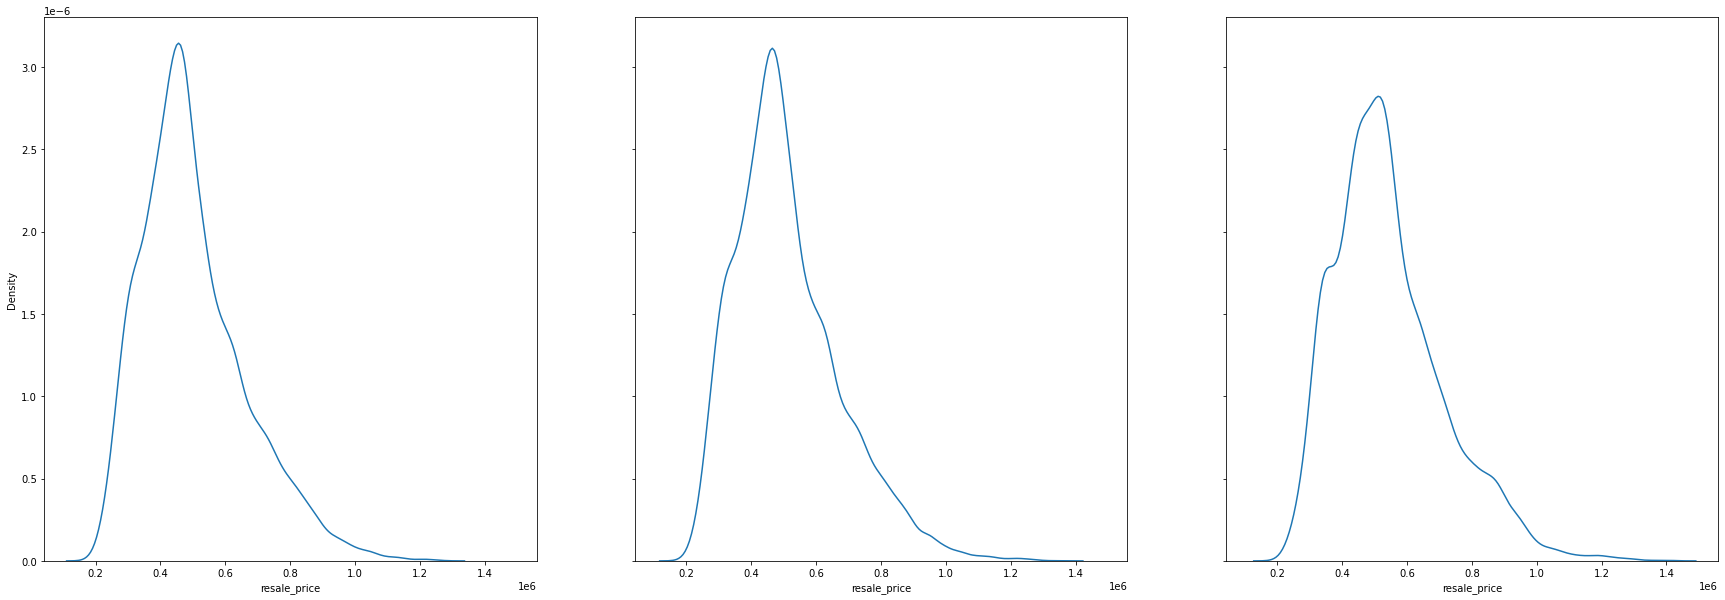

In [ ]:
fig, axes = plt.subplots(1, 3,figsize=(30,10),sharex=True,sharey=True)
sns.kdeplot(data=old_test_dataframe,x='resale_price',ax=axes[0])
sns.kdeplot(data=new_test_dataframe_2021,x='resale_price',ax=axes[1])
sns.kdeplot(data=new_test_dataframe_2022,x='resale_price',ax=axes[2])
plt.show()

The resale price follows more or less the same distribution, but we can see for 2022 the distribution is shorter with a slight peak at 0.4 e^6. It indicates a change in P(Y) and hence a label shift.

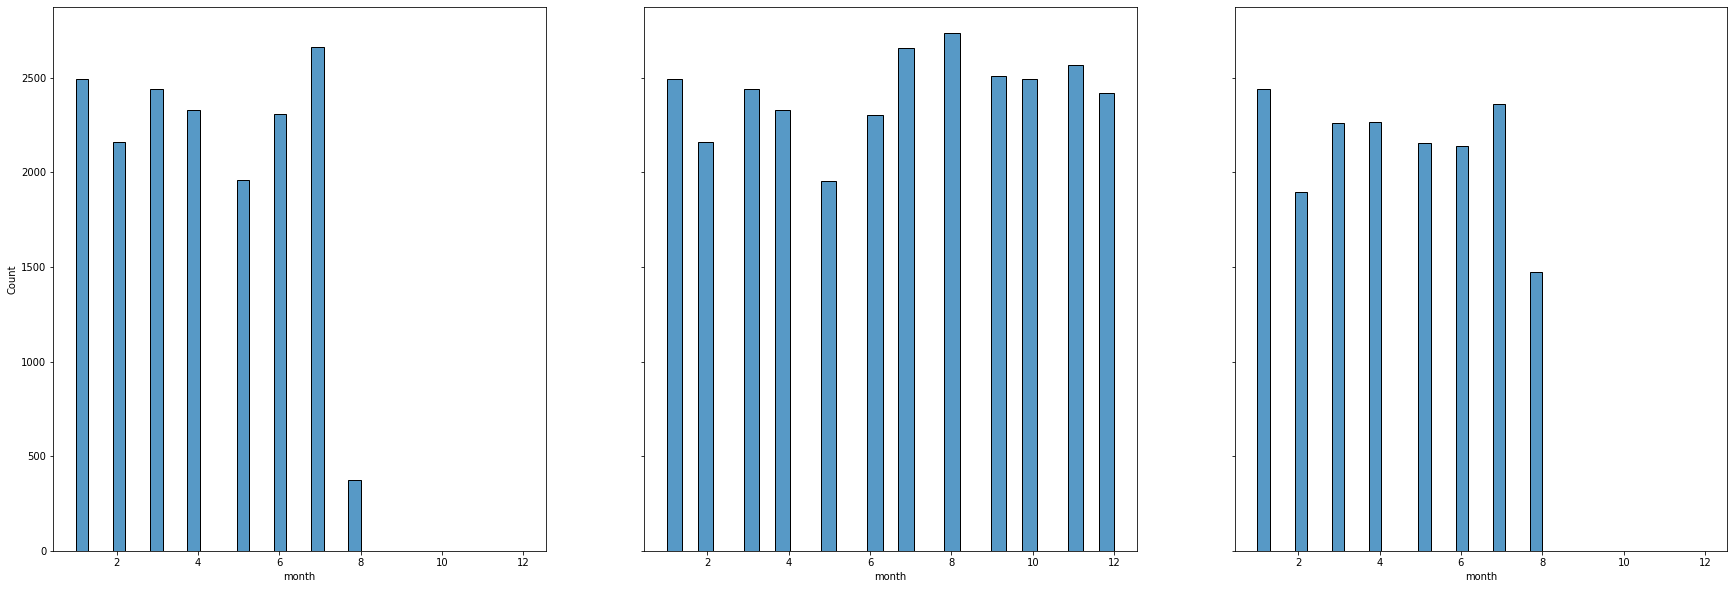

In [ ]:
fig, axes = plt.subplots(1, 3,figsize=(30,10),sharex=True,sharey=True)
sns.histplot(data=old_test_dataframe,x='month',ax=axes[0])
sns.histplot(data=new_test_dataframe_2021,x='month',ax=axes[1])
sns.histplot(data=new_test_dataframe_2022,x='month',ax=axes[2])
plt.show()

The month distribution is also obviously different for the 3 dataset. It indicates a change in P(X), and hence it is a covariate shift.

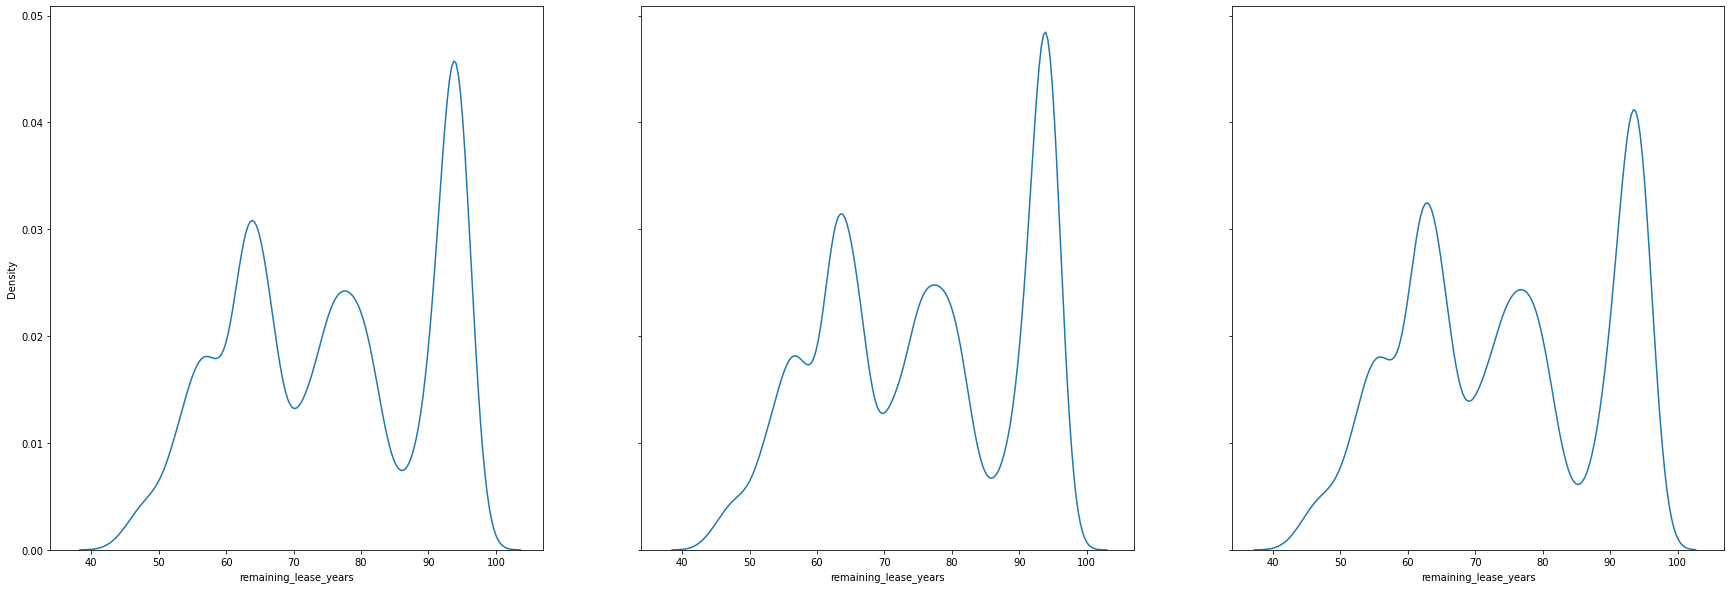

In [ ]:
fig, axes = plt.subplots(1, 3,figsize=(30,10),sharex=True,sharey=True)
sns.kdeplot(data=old_test_dataframe,x='remaining_lease_years',ax=axes[0])
sns.kdeplot(data=new_test_dataframe_2021,x='remaining_lease_years',ax=axes[1])
sns.kdeplot(data=new_test_dataframe_2022,x='remaining_lease_years',ax=axes[2])
plt.show()

The remaining_lease_years also has some shift. For 2022 data, the plot is also shorter and wider

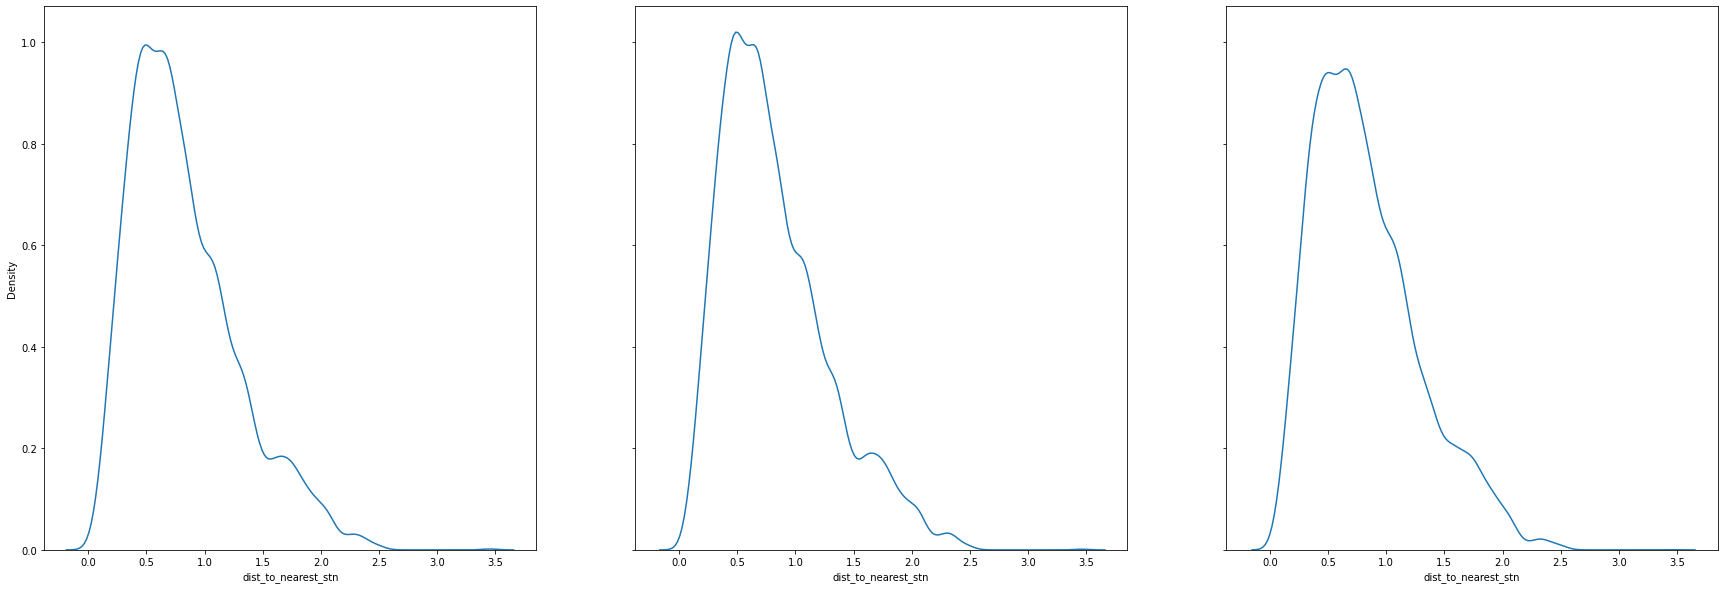

In [ ]:
fig, axes = plt.subplots(1, 3,figsize=(30,10),sharex=True,sharey=True)
sns.kdeplot(data=old_test_dataframe,x='dist_to_nearest_stn',ax=axes[0])
sns.kdeplot(data=new_test_dataframe_2021,x='dist_to_nearest_stn',ax=axes[1])
sns.kdeplot(data=new_test_dataframe_2022,x='dist_to_nearest_stn',ax=axes[2])
plt.show()

dist_to_nearest_stn also shows a degree of shift. The distance with the highest probability is shifted to the right gradually over the years

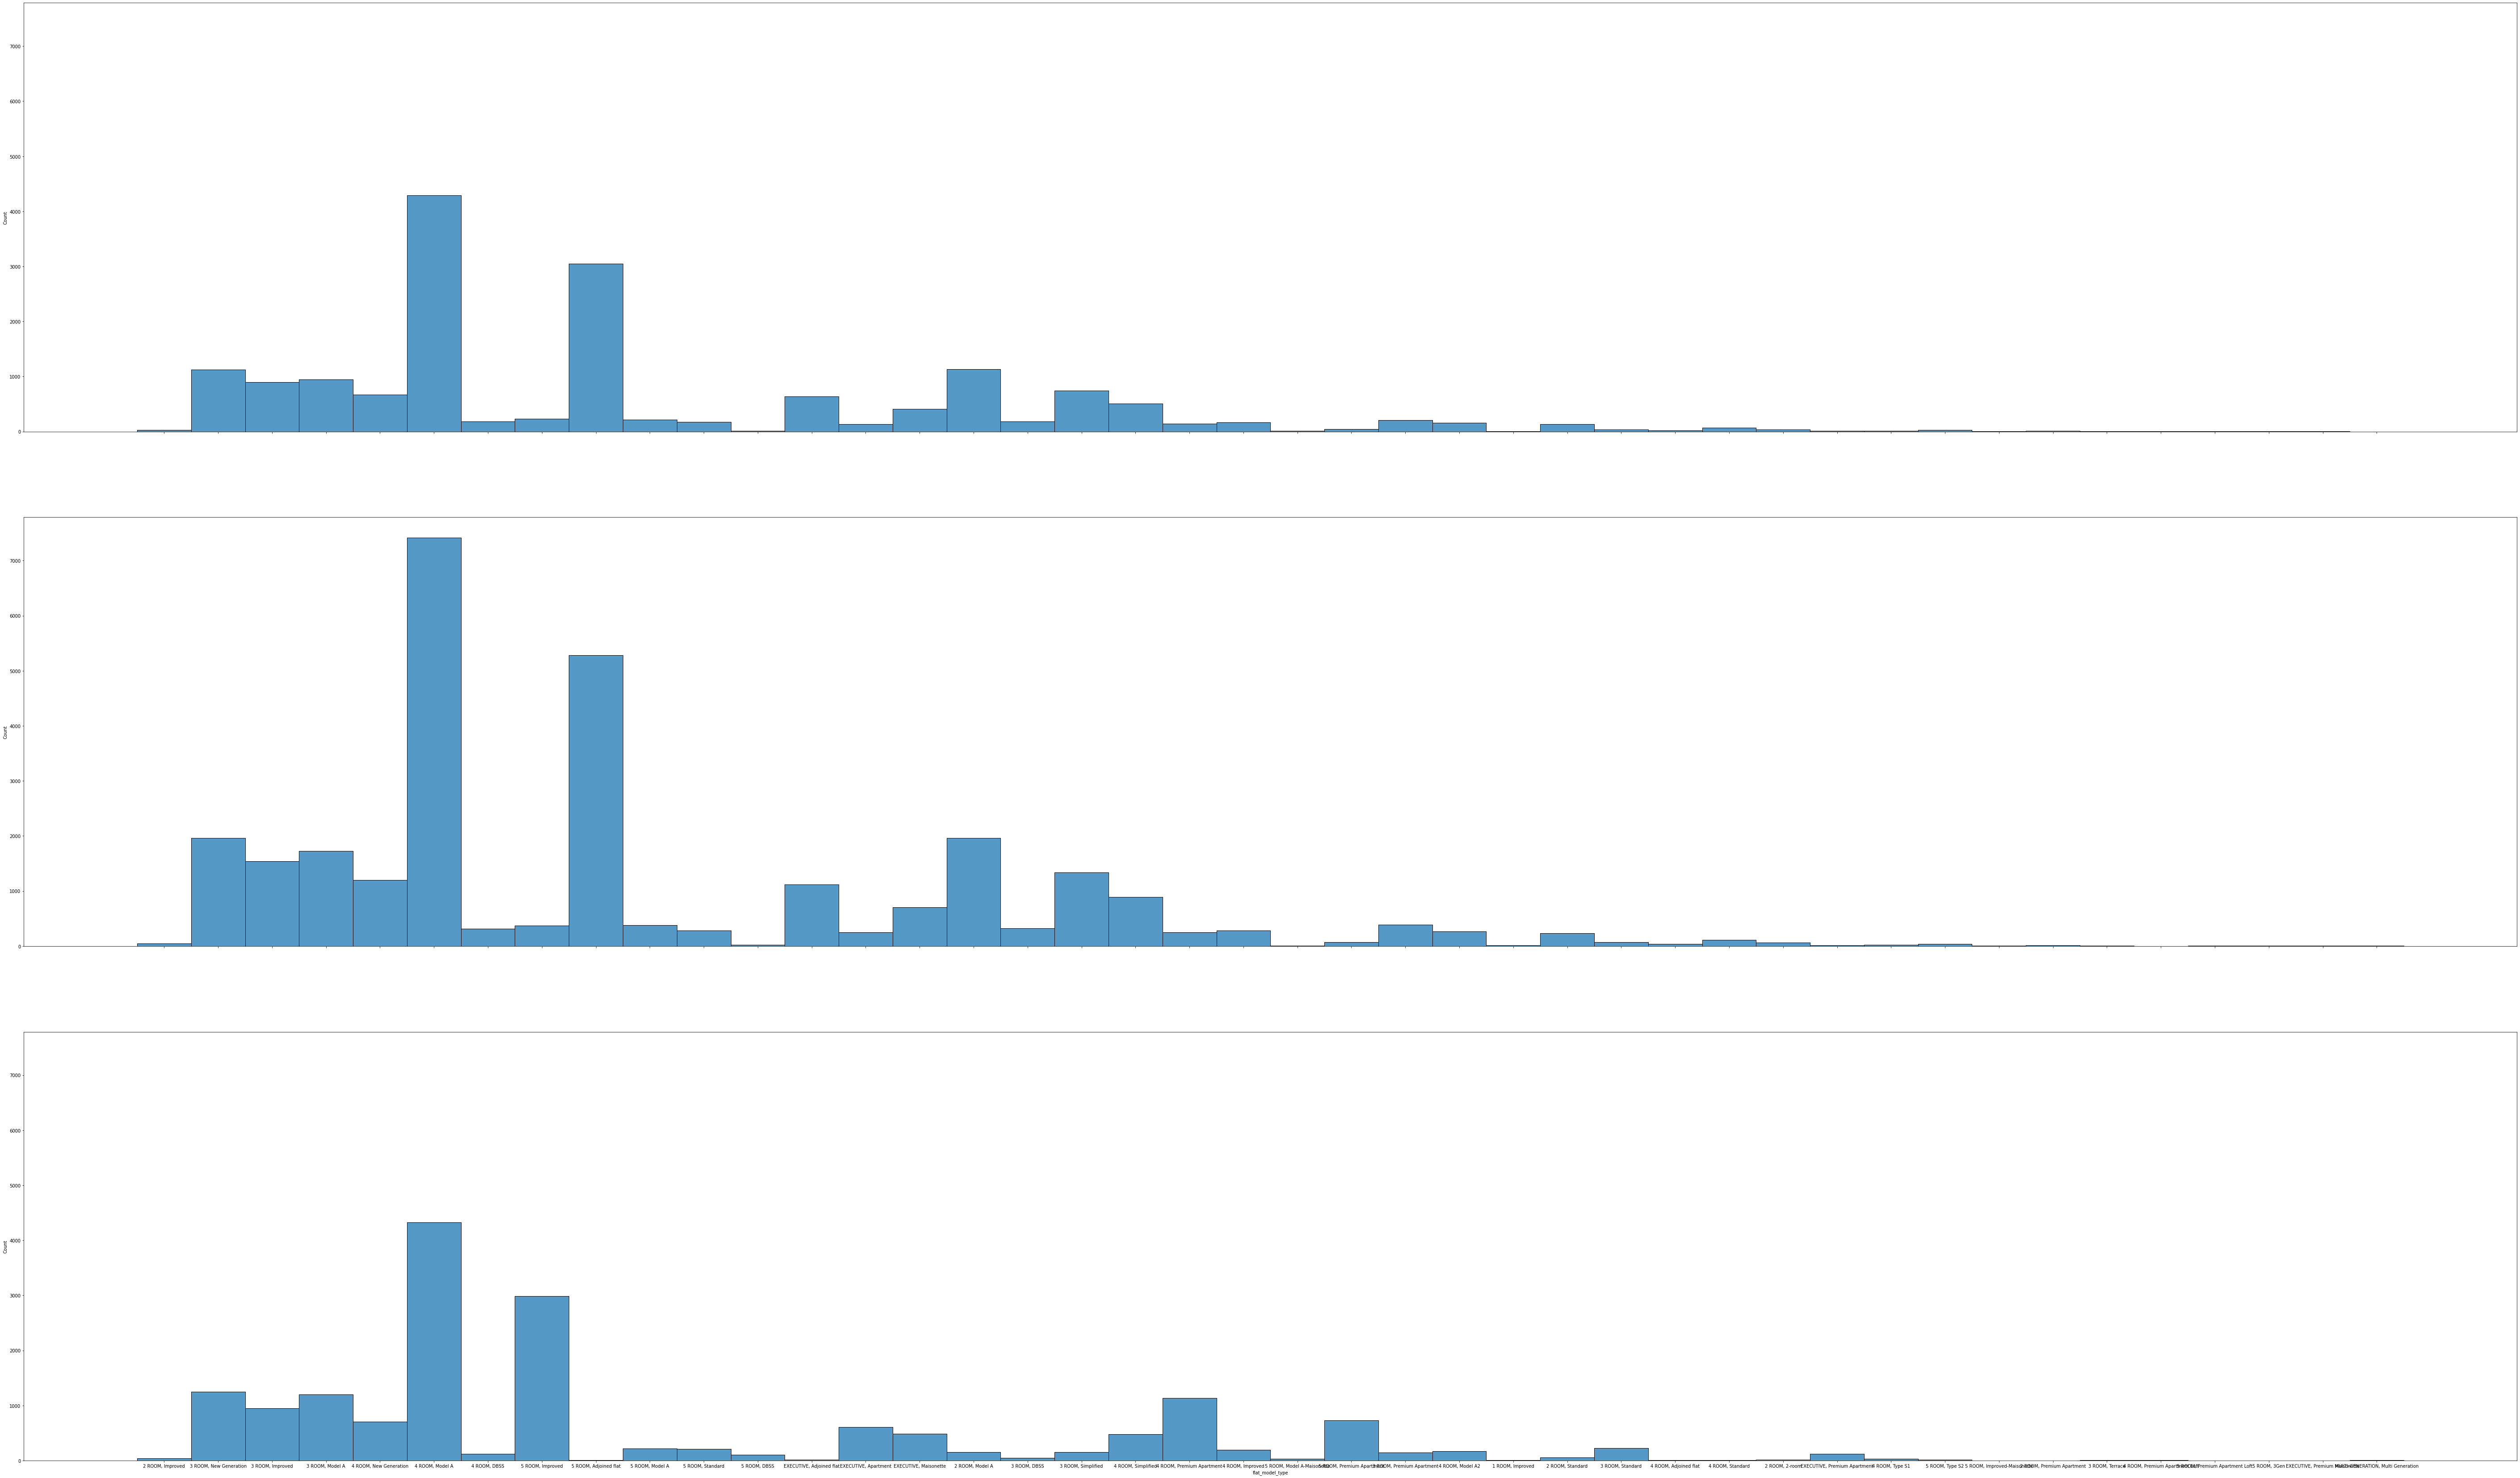

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(100,60),sharex=True,sharey=True)
sns.histplot(data=old_test_dataframe,x='flat_model_type',ax=axes[0])
sns.histplot(data=new_test_dataframe_2021,x='flat_model_type',ax=axes[1])
sns.histplot(data=new_test_dataframe_2022,x='flat_model_type',ax=axes[2])
plt.show()

There is also an obvious shift from the flat model type distribution. Aside from the additional model types mentioned above, there is an increase in 5 ROOM IMPROVED and a decrease in 5 ROOM, ADJOINED FLAT. This is a covariate shift.

# Question 3 part d

In [ ]:
from time import time

In [ ]:
train_dataframe = df[df['year']<=2020]
val_dataframe = df[df['year']>2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [ ]:
start = time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    numerical=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
    encoded=[]
    input=[]
    for item in numerical:
      encoded_item=keras.Input(shape=(1,), name=item)
      input.append(encoded_item)
      encoded.append(encode_numerical_feature(encoded_item, item, train_ds))


    month=keras.Input(shape=(1,), name='month',dtype="int64")
    input.append(month)
    encoded.append(embed_and_flatten(month,'month',train_ds,False))

    flat_model_type=keras.Input(shape=(1,), name='flat_model_type',dtype="string")
    input.append(flat_model_type)
    encoded.append(embed_and_flatten(flat_model_type,'flat_model_type',train_ds,True))

    storey_range=keras.Input(shape=(1,), name='storey_range',dtype="string")
    input.append(storey_range)
    encoded.append(embed_and_flatten(storey_range,'storey_range',train_ds,True))

    all_features_input=input

    selected_inputs = []
    selected_features=[]
    print('going through feature_mask: stage 1', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    print('going through feature_mas: stage 2', feature_mask)
    for i,j in zip(encoded, feature_mask):
        if j == 1:
            selected_features.append(i)
            print(i)
        else:
            print('Skipping', i)

    encoded_features = layers.concatenate(selected_features)
    x=Dense(NEURON,activation='relu')(encoded_features)
    x=Dense(1)(x)
    model = keras.Model(selected_inputs, x)
    model.compile(tf.keras.optimizers.Adam(learning_rate=LR), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error')])
    history=model.fit(train_ds, verbose=0, epochs=EPOCH, batch_size=BATCH_SIZE,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], 
                      validation_data=val_ds)
    
    val_loss_hx = history.history['val_root_mean_squared_error']
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time() - start, 'seconds elapsed')
    print()

print(all_losses)


vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask: stage 1 [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


new min loss: len 9, ix 0
session cleared!

ix 1 i 1
updated temp_vec [1, 0, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask: stage 1 [1, 0, 1, 1, 1, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years',

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 2 i 1
updated temp_vec [1, 1, 0, 1, 1, 1, 1, 1, 1]
going through feature_mask: stage 1 [1, 1, 0, 1, 1, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


new min loss: len 9, ix 2
session cleared!

ix 3 i 1
updated temp_vec [1, 1, 1, 0, 1, 1, 1, 1, 1]
going through feature_mask: stage 1 [1, 1, 1, 0, 1, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years',

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 4 i 1
updated temp_vec [1, 1, 1, 1, 0, 1, 1, 1, 1]
going through feature_mask: stage 1 [1, 1, 1, 1, 0, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 5 i 1
updated temp_vec [1, 1, 1, 1, 1, 0, 1, 1, 1]
going through feature_mask: stage 1 [1, 1, 1, 1, 1, 0, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by layer 'rem

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 6 i 1
updated temp_vec [1, 1, 1, 1, 1, 1, 0, 1, 1]
going through feature_mask: stage 1 [1, 1, 1, 1, 1, 1, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by layer 'rem

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


new min loss: len 9, ix 6
session cleared!

ix 7 i 1
updated temp_vec [1, 1, 1, 1, 1, 1, 1, 0, 1]
going through feature_mask: stage 1 [1, 1, 1, 1, 1, 1, 1, 0, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', descript

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 8 i 1
updated temp_vec [1, 1, 1, 1, 1, 1, 1, 1, 0]
going through feature_mask: stage 1 [1, 1, 1, 1, 1, 1, 1, 1, 0]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by layer 'rem

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

2420.7387883663177 seconds elapsed

vec [1, 1, 1, 1, 1, 1, 0, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 0, 1, 1]
going through feature_mask: stage 1 [0, 1, 1, 1, 1, 1, 0, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_le

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 1 i 1
updated temp_vec [1, 0, 1, 1, 1, 1, 0, 1, 1]
going through feature_mask: stage 1 [1, 0, 1, 1, 1, 1, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 2 i 1
updated temp_vec [1, 1, 0, 1, 1, 1, 0, 1, 1]
going through feature_mask: stage 1 [1, 1, 0, 1, 1, 1, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 3 i 1
updated temp_vec [1, 1, 1, 0, 1, 1, 0, 1, 1]
going through feature_mask: stage 1 [1, 1, 1, 0, 1, 1, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 4 i 1
updated temp_vec [1, 1, 1, 1, 0, 1, 0, 1, 1]
going through feature_mask: stage 1 [1, 1, 1, 1, 0, 1, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 5 i 1
updated temp_vec [1, 1, 1, 1, 1, 0, 0, 1, 1]
going through feature_mask: stage 1 [1, 1, 1, 1, 1, 0, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by layer 'rem

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 6 i 0
ix 7 i 1
updated temp_vec [1, 1, 1, 1, 1, 1, 0, 0, 1]
going through feature_mask: stage 1 [1, 1, 1, 1, 1, 1, 0, 0, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

ix 8 i 1
updated temp_vec [1, 1, 1, 1, 1, 1, 0, 1, 0]
going through feature_mask: stage 1 [1, 1, 1, 1, 1, 1, 0, 1, 0]
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_nearest_stn'), name='dist_to_nearest_stn', description="created by layer 'dist_to_nearest_stn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='dist_to_dhoby'), name='dist_to_dhoby', description="created by layer 'dist_to_dhoby'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='degree_centrality'), name='degree_centrality', description="created by layer 'degree_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='eigenvector_centrality'), name='eigenvector_centrality', description="created by layer 'eigenvector_centrality'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='remaining_lease_years'), name='remaining_lease_years', description="created by layer 'rem

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


session cleared!

4219.968925476074 seconds elapsed

[[85894.359375, 104515.828125, 85543.5546875, 87373.703125, 89590.3125, 87532.921875, 82717.8671875, 93678.6328125, 93455.484375], [87220.734375, 105057.46875, 83202.3515625, 85755.671875, 87995.859375, 85427.515625, 95078.6875, 90176.0625]]


# Q3 part e

In [ ]:
min_loss_vec

[1, 1, 1, 1, 1, 1, 0, 1, 1]

From above we can see the removed feature is month.

The more important feature is dist_to_dhoby, flat_model_type and storey_range, as they lead to a higher test loss.

Concept drift has indeed occured as they are different from what is mentioned in the question.


# Conclusion

**In Q2, we tried out another approach of model tuning. KerasTuner offers many other algorithms how do Bayesian optimisation or HyperBand work? Are they necessarily better than random search? Also, is random search better than grid search?**

Bayesian keeps track of the previous score and form a probability that P(score|hp) to guide its search. It saves time if the hp are all concentrated in a small area, so it will focus on that small area to find out what is the best hp. It is not necessarily better, because the hp distribution can be there is some hp together will good score, but the actual best-scoring hp lies far away from this group, and bayesian might end up ignore the actual-best one in favor of one of the hp sets in the small area.

Hyperband run a lot of random configurations first, but each configuration is not run for very long. Then, it chooses the best n to run for more iterations, and then again choose k (k < n) among n to run for more iterations, until the best configuration is found. It is also a fast way of finding the best configuration, but it takes up more space than random search since it need to store so many configuration first.

Grid search is to divide the hp combinations into grids and uniformly sample points inside to calculate score for each configuration. Grid search obviously will take longer as it evaluates every possible combinations, but it guarantees to yield the where the optimised result lie in. Random search is just randomly sample points in the all possible combinations. It is fast, and it might discover good result, but it does not guarantee the result is the true optimal one.

